# CIFAR-10 Luokitteluprojekti (FCN)


#### Data preparation

In [1]:
from keras.src.utils import to_categorical
import keras

(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

X_train = X_train.reshape(-1, 32 * 32 * 3)
X_test = X_test.reshape(-1, 32 * 32 * 3)

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

Training data shape: (50000, 3072)
Test data shape: (10000, 3072)


#### Modeling

In [2]:
from keras import backend as K
from keras import layers

print(K.backend())

# Create the model
inputs = keras.Input(shape=(3072,))
x = layers.Dense(256, activation="relu")(inputs)
x = layers.Dense(128, activation="relu")(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs, name="cifar10_model")

tensorflow


In [3]:
model.summary()

Model: "cifar10_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       786,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 820,874 (3.13 MB)

 Trainable params: 820,874 (3.13 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
model.compile(
    loss=keras.losses.CategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(),
    metrics=["accuracy"],
)

early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=4,
    min_delta=0.001,
    restore_best_weights=True
)

history = model.fit(X_train, y_train, batch_size=256, epochs=30, validation_split=0.2, callbacks=[early_stop])


Epoch 1/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.2355 - loss: 2.1241 - val_accuracy: 0.3431 - val_loss: 1.8483
Epoch 2/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3617 - loss: 1.8032 - val_accuracy: 0.3689 - val_loss: 1.7823
Epoch 3/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.3991 - loss: 1.7042 - val_accuracy: 0.3860 - val_loss: 1.7439
Epoch 4/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4149 - loss: 1.6569 - val_accuracy: 0.4162 - val_loss: 1.6505
Epoch 5/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4283 - loss: 1.6061 - val_accuracy: 0.4328 - val_loss: 1.6017
Epoch 6/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4455 - loss: 1.5641 - val_accuracy: 0.4315 - val_loss: 1.6122
Epoch 7/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4623 - loss: 1.5195 - val_accuracy: 0.4459 - val_loss: 1.5793
Epoch 8/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4695 - loss: 1.5035 - val_accur

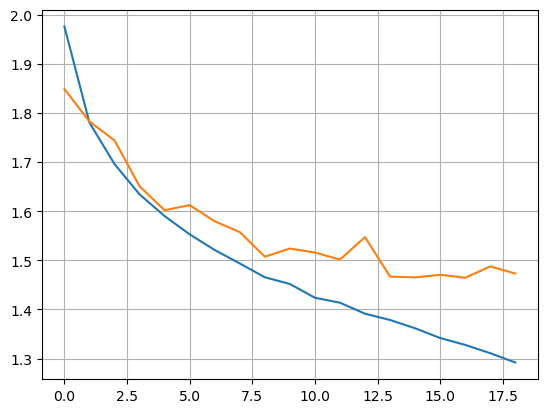

In [5]:
from matplotlib import pyplot as plt

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.grid()
plt.show()

In [6]:
test_scores = model.evaluate(X_test, y_test, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

313/313 - 1s - 2ms/step - accuracy: 0.4898 - loss: 1.4460
Test loss: 1.4459967613220215
Test accuracy: 0.48980000615119934


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


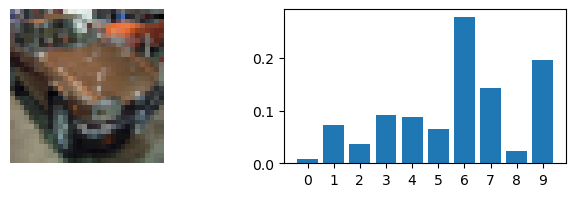

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


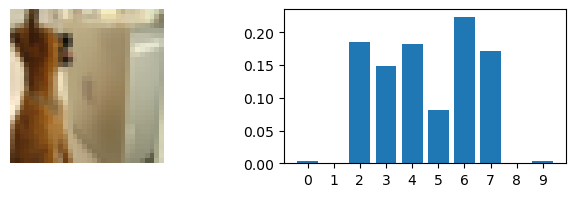

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


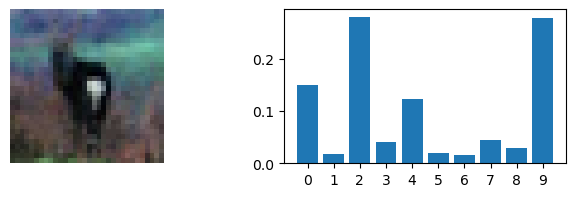

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


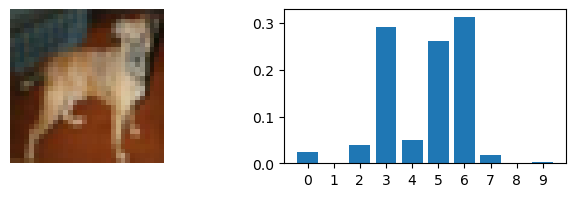

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


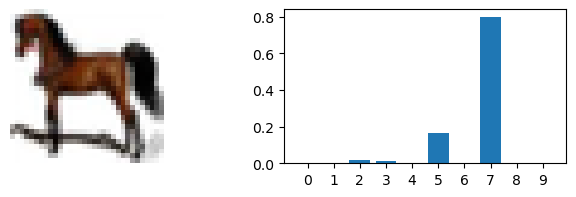

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


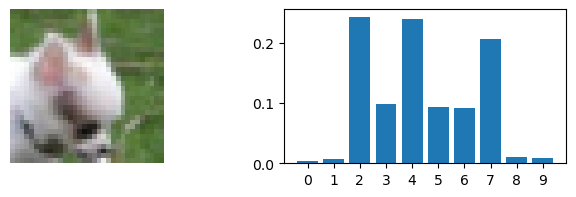

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


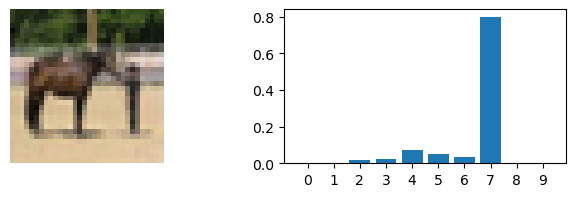

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


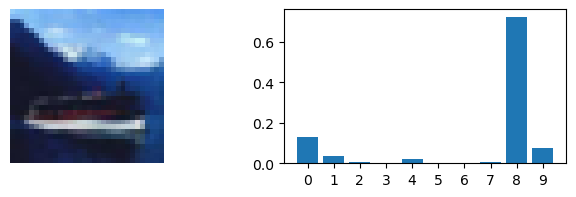

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


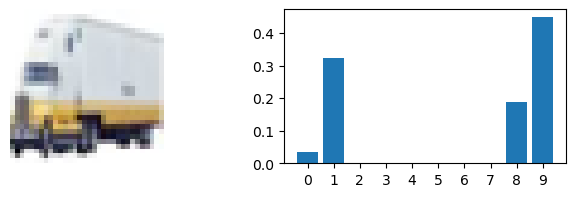

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


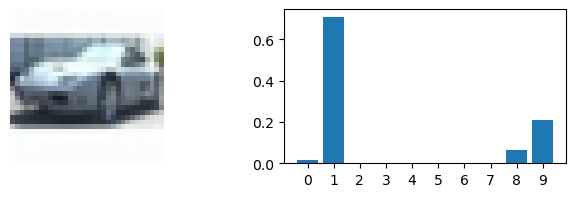

In [7]:
import numpy as np

start = 2000

for k in range(10):
    plt.figure(figsize=(8, 2))

    # Get one image
    x = np.expand_dims(X_test[start + k], axis=0)

    # Predict
    y = model.predict(x)[0]

    # Show the image
    plt.subplot(1, 2, 1)
    plt.imshow(X_test[start + k].reshape(32, 32, 3))
    plt.axis("off")

    # Show the prediction probabilities
    plt.subplot(1, 2, 2)
    plt.bar(np.arange(10), y)
    plt.xticks(range(10))

    plt.show()
